In [2]:
# import de nodige packages
import os
import sys
import re
import math
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split

import networkx as nx
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from functions.data_loader import data_loader
from classes.smiles_to_graph import MolecularGraphFromSMILES

# Load the data and couple the SMILES to the yields and remove nan's

In [3]:

yields_path = "data/compounds_yield.csv"
smiles_path = "data/compounds_smiles.csv"

df_merged = data_loader(yields_path, smiles_path)


print("Merged DataFrame:")
print(df_merged)


Merged DataFrame:
   compound_id  ... yield
0        comp1  ...    68
1        comp2  ...    86
2        comp3  ...    94
3        comp4  ...    72
4        comp5  ...    81
..         ...  ...   ...
78      comp88  ...    73
79      comp91  ...    45
80      comp92  ...    15
81      comp93  ...    10
82      comp97  ...    72

[83 rows x 4 columns]


Convert the SMILES to Graphs

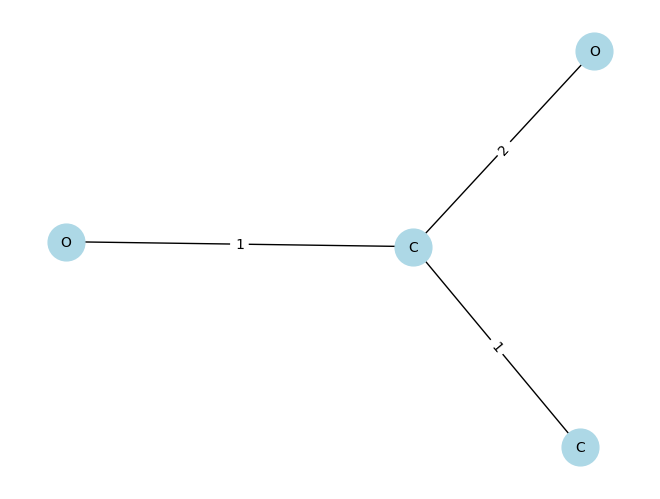

Data(x=[4, 16], edge_index=[2, 6], edge_attr=[6, 3])


In [4]:
# Create a molecule from a SMILES string
smiles = "CC(=O)O"  
mol_graph = MolecularGraphFromSMILES(smiles)

# Visualize the molecule with bond orders
mol_graph.visualize()

# Convert to PyTorch Geometric format
pyg_data = mol_graph.to_pyg_data()
print(pyg_data)

## Zet de SMILES om naar graphs

In [5]:

graphs = []
for _, row in tqdm(df_merged.iterrows(), total=len(df_merged), desc="Converting SMILES to graphs"):
    try:
        graph = MolecularGraphFromSMILES(row['smiles_raw']).to_pyg_data()
        graph.y = torch.tensor([row['yield']], dtype=torch.float)
        graphs.append(graph)
    except Exception as e:
        print(f"Fout bij SMILES: {row['smiles_raw']}, error: {e}")


Converting SMILES to graphs: 100%|██████████| 83/83 [00:01<00:00, 81.45it/s] 


## Zet de graphs in een dataloader zodat het de GNN in kan

In [6]:
# Split de lijst met graphs
train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)

# Maak DataLoaders aan voor training en evaluatie
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

/opt/anaconda3/envs/sobo/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
for batch in train_loader:
    x = batch.x
    edge_index = batch.edge_index
    edge_attr = batch.edge_attr
    y = batch.y
    batch_vector = batch.batch